# Promotion Campaign

## Motivation

Many companies in various sectors make strategic campaigns.
We have the challenge of designing the upcoming promotion campaign for a Soda Company. The intended objective is to bolster sales while at the same time obeying various business constraints.

To design an optimal campaign, we need to account for trends in the market directly in the MIP model. However, due to the stochastic nature of the market, it is difficult to do so with only hard constraints of a MIP model.

In addition, it would be helpful to have an idea about the risk associated to our decisions: do our decisions always satisfy the business constraints?

## Problem Description


We need to predict impact of different price points on the expected sales for each type of soda.
To do this, we need to train a soda sales predictor from a historical data table to evaluate the impact of different discounts.

Thus, we need to find the best predictor (regressor) by using the historical data. Then, we will use all the available data to train the selected predictor and generate sales predictions for the campaign.
Based on these predictions, we decide which sodas will be discounts in the promotion. 

Lastly, we evaluate the risk of our campaign by generating different scenarios relying on the stochastic nature of Machine Learning models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset & preprocessing

Historical data

In [2]:
dataset = pd.read_csv('./SodaSales.csv')
dataset.head()

,Product,Sales,Cost Per Unit,Easter Included,Super Bowl Included,Christmas Included,Other Holiday,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 weeks,Sales M-5 weeks,Family
0,11 Down,51.9,1.6625,No,No,Yes,No,80.69,69.19,17.0,22.4,13.5,14.5,28.0,Clear
1,Alpine Stream,55.8,2.2725,No,No,Yes,No,80.69,69.19,2.4,2.2,2.0,1.4,0.5,Clear
2,Bright,3385.6,1.3475,No,No,Yes,No,80.69,69.19,301.8,188.8,101.4,81.6,213.8,Clear
3,Crisp Clear,63.5,1.6600,No,No,Yes,No,80.69,69.19,73.8,69.4,72.8,75.4,57.4,Clear
4,Popsi Kola,181.1,1.8725,No,No,Yes,No,80.69,69.19,23.1,22.6,22.1,19.9,23.2,Dark


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product              596 non-null    object 
 1   Sales                596 non-null    float64
 2   Cost Per Unit        596 non-null    float64
 3   Easter Included      596 non-null    object 
 4   Super Bowl Included  596 non-null    object 
 5   Christmas Included   596 non-null    object 
 6   Other Holiday        596 non-null    object 
 7   4 Wk Avg Temp        596 non-null    float64
 8   4 Wk Avg Humidity    596 non-null    float64
 9   Sales M-1 weeks      596 non-null    float64
 10  Sales M-2 weeks      596 non-null    float64
 11  Sales M-3 weeks      596 non-null    float64
 12  Sales M-4 weeks      596 non-null    float64
 13  Sales M-5 weeks      596 non-null    float64
 14  Family               596 non-null    object 
dtypes: float64(9), object(6)
memory usage: 7

In [4]:
dataset.describe()

,Sales,Cost Per Unit,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 weeks,Sales M-5 weeks
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,508.641946,2.138003,79.209564,71.181242,131.159564,130.590772,128.673154,126.161074,125.697315
std,756.407688,0.759890,1.929113,2.494170,222.228640,216.656859,212.700112,207.967128,207.935168
min,15.900000,1.192500,75.830000,67.590000,1.900000,1.900000,1.900000,1.400000,0.500000
25%,75.325000,1.546250,77.570000,69.070000,16.300000,14.650000,13.375000,14.475000,14.250000
50%,226.150000,1.925000,79.720000,70.750000,40.000000,39.150000,37.450000,37.450000,36.850000
75%,578.900000,2.576875,80.940000,72.850000,140.725000,142.650000,140.300000,138.700000,138.700000
max,4910.400000,4.177500,81.610000,76.470000,1751.600000,1751.600000,1751.600000,1751.600000,1751.600000


**Normalize numerical features**

Options:
- Min-max scaling: $f_i = \frac{f_i - \min(f_i)}{\max(f_i) - \min(f_i)}$
- Standard scaling: $f_i = \frac{f_i - \text{avg}(f_i)}{\text{std}(f_i)}$
- Many others: [scaling options](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

In [5]:
from sklearn.preprocessing import StandardScaler

numerical_columns = [
    'Cost Per Unit',
    '4 Wk Avg Temp',
    '4 Wk Avg Humidity',
    'Sales M-1 weeks',
    'Sales M-2 weeks',
    'Sales M-3 weeks',
    'Sales M-4 weeks',
    'Sales M-5 weeks',
]

scaler = StandardScaler()
dataset.loc[:, numerical_columns] = scaler.fit_transform(dataset.loc[:, numerical_columns])
dataset.describe()

,Sales,Cost Per Unit,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 weeks,Sales M-5 weeks
count,596.000000,5.960000e+02,5.960000e+02,5.960000e+02,5.960000e+02,5.960000e+02,5.960000e+02,5.960000e+02,5.960000e+02
mean,508.641946,-2.980464e-17,-2.312840e-15,-5.531742e-15,-9.537486e-17,1.192186e-17,-2.384372e-17,2.384372e-17,-8.345301e-17
std,756.407688,1.000840e+00,1.000840e+00,1.000840e+00,1.000840e+00,1.000840e+00,1.000840e+00,1.000840e+00,1.000840e+00
min,15.900000,-1.245309e+00,-1.753346e+00,-1.441064e+00,-5.821398e-01,-5.944832e-01,-5.965189e-01,-6.004116e-01,-6.026036e-01
25%,75.325000,-7.793898e-01,-8.506196e-01,-8.471817e-01,-5.172873e-01,-5.355850e-01,-5.425244e-01,-5.374883e-01,-5.364217e-01
50%,226.150000,-2.805437e-01,2.648187e-01,-1.730451e-01,-4.105508e-01,-4.224080e-01,-4.292418e-01,-4.269213e-01,-4.276426e-01
75%,578.900000,5.780315e-01,8.977650e-01,6.696257e-01,4.307938e-02,5.570725e-02,5.470901e-02,6.034347e-02,6.258492e-02
max,4910.400000,2.686192e+00,1.245367e+00,2.122230e+00,7.297896e+00,7.488204e+00,7.636527e+00,7.822411e+00,7.825845e+00


**Convert categorical**

In [6]:
categorical_columns = [
    'Product',
    'Family',
    'Easter Included',
    'Super Bowl Included', 
    'Christmas Included', 
    'Other Holiday'
]

for c in categorical_columns:
    print(c.upper())
    print(dataset[c].value_counts(), '\n')

PRODUCT
Alpine Stream    86
11 Down          79
Popsi Kola       75
Mr. Popper       73
Crisp Clear      70
Koala Kola       61
Bright           60
DC Kola          46
AB Root Beer     46
Name: Product, dtype: int64 

FAMILY
Dark     301
Clear    295
Name: Family, dtype: int64 

EASTER INCLUDED
No     547
Yes     49
Name: Easter Included, dtype: int64 

SUPER BOWL INCLUDED
No     512
Yes     84
Name: Super Bowl Included, dtype: int64 

CHRISTMAS INCLUDED
No     560
Yes     36
Name: Christmas Included, dtype: int64 

OTHER HOLIDAY
No    596
Name: Other Holiday, dtype: int64 



In [7]:
dataset = pd.get_dummies(
    dataset, 
    columns = categorical_columns
)
dataset.head()

,Sales,Cost Per Unit,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 weeks,Sales M-5 weeks,Product_11 Down,...,Product_Popsi Kola,Family_Clear,Family_Dark,Easter Included_No,Easter Included_Yes,Super Bowl Included_No,Super Bowl Included_Yes,Christmas Included_No,Christmas Included_Yes,Other Holiday_No
0,51.9,-0.626279,0.768063,-0.799029,-0.514135,-0.499784,-0.541936,-0.537368,-0.470240,1,...,0,1,0,1,0,1,0,0,1,1
1,55.8,0.177144,0.768063,-0.799029,-0.579888,-0.593097,-0.596048,-0.600412,-0.602604,0,...,0,1,0,1,0,1,0,0,1,1
2,3385.6,-1.041161,0.768063,-0.799029,0.768505,0.268896,-0.128331,-0.214450,0.424059,0,...,0,1,0,1,0,1,0,0,1,1
3,63.5,-0.629571,0.768063,-0.799029,-0.258327,-0.282669,-0.262906,-0.244287,-0.328731,0,...,0,1,0,1,0,1,0,0,1,1
4,181.1,-0.349691,0.768063,-0.799029,-0.486662,-0.498860,-0.501470,-0.511380,-0.493343,0,...,1,0,1,1,0,1,0,0,1,1


In [8]:
#
x = dataset.drop('Sales', axis=1)
y = dataset.Sales

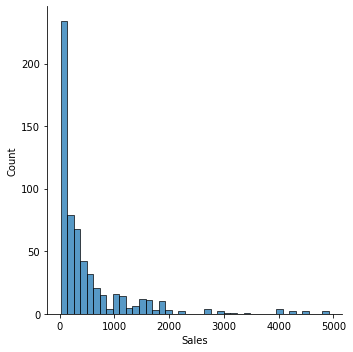

count     596.000000
mean      508.641946
std       756.407688
min        15.900000
25%        75.325000
50%       226.150000
75%       578.900000
max      4910.400000
Name: Sales, dtype: float64

In [9]:
# Plot distribution
sns.displot(y)
plt.show()
y.describe()

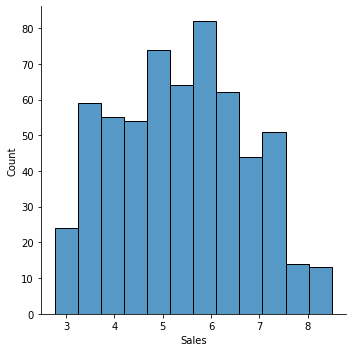

count    596.000000
mean       5.384135
std        1.348959
min        2.766319
25%        4.321775
50%        5.421186
75%        6.361130
max        8.499111
Name: Sales, dtype: float64

In [10]:
y = np.log(y)

# Plot distribution
sns.displot(y)
plt.show()
y.describe()

---
## Regressors

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

### Hyperparameters Optimization

Hyper-parameters are parameters that are not directly learnt within estimators.
Two generic approaches to parameter search are provided in scikit-learn: 
- GridSearchCV exhaustively considers all parameter combinations.
- RandomizedSearchCV can sample a given number of candidates from a parameter space with a specified distribution.

In [12]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

# Model to optimize 
reg = Ridge(fit_intercept=True)
# Hyperparameters of the model
hpo_space = {
    'alpha': stats.uniform(0, 50)
}

# Random Search
rand_search = RandomizedSearchCV(
    estimator=reg,
    param_distributions=hpo_space,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    refit=False,
    cv=10,
    random_state=12345
)
rand_search.fit(x, y)

# Best alpha
print(f"Best alpha = {rand_search.best_params_['alpha']:.5f}")
print(f"Best score = {-rand_search.best_score_:.5f}")

Best alpha = 0.41941
Best score = 0.53456


In [13]:
# Model to optimize 
reg = DecisionTreeRegressor(criterion="squared_error")
# Hyperparameters of the model
hpo_space = {
    'min_samples_split': list(range(5, 30)),
    'min_samples_leaf': list(range(5, 50))
}

# Random Search
rand_search = RandomizedSearchCV(
    estimator=reg,
    param_distributions=hpo_space,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    refit=False,
    cv=10,
    random_state=12345
)
rand_search.fit(x, y)

# Best alpha
print(f"Best min_sample_split = {rand_search.best_params_['min_samples_split']:.2f}")
print(f"Best min_sample_leaf = {rand_search.best_params_['min_samples_leaf']:.2f}")
print(f"Best score = {-rand_search.best_score_:.5f}")

Best min_sample_split = 13.00
Best min_sample_leaf = 6.00
Best score = 0.35855



### Pick the right Regressor
**Picking the right predictor is of upmost importance**. <br>
To compare different regression models, we have to:

1. Decide the right metrics for our task ($\hat{y}$ is the predicted value):
    - Mean Absolute Error: $MAE = \frac{1}{N} \sum_{i = 1}^{N} |y_i - \hat{y_i}|$
    - Mean Absolute Percentage Error: $MAPE = \frac{1}{N} \sum_{i = 1}^{N} \frac{|y_i - \hat{y_i}|}{\max(\epsilon, |y_i|)}$
    - Mean Squared Error: $MSE = \frac{1}{N} \sum_{i = 1}^{N} (y_i - \hat{y_i})^{2}$
    - Max Error: $MaxE = \max_{i = \{1, \dots, N\}} (|y_i - \hat{y_i}|)$

2. In supervised learning, always compare the estimators against simple rules of thumb. For regression task, we can use:
    - *Mean* always predicts the mean of the training targets.
    - *Median* always predicts the median of the training targets.
    - *Quantile* always predicts a user provided quantile of the training targets.
    
3. Visually assess the quality of the regression models:
    - Plot the actual values vs predicted values.
    - Plot the the residuals (i.e. the difference between the actual and the predicted values) vs. the predicted values.
    
**Finally, resist the temptation to overfit!** <br>
By repeatedly splitting, training, and testing, you can create a realistic simulation of prediction accuracy.
We have al least two options here:

1. Split the dataset multiple times by randomly shuffling the data.
2. Cross validation.


In [14]:
from sklearn.metrics import median_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import max_error
    
def evaluate(y_pred, y, name='Train'):
    """
    Evaluate the predictions of a regressor.
    
    Args:
        y_pred: (array-like)
            Predictions.
        y: (array-like)
            Target output.
    """    
    # print info
    print(f'{name}:')
    print(f"\t- MAE: {median_absolute_error(y, y_pred):.5f}")
    print(f"\t- MAPE: {mean_absolute_percentage_error(y, y_pred):.5f}")
    print(f"\t- MSE: {mean_squared_error(y, y_pred):.5f}")
    print(f"\t- R2: {r2_score(y, y_pred):.5f}")
    print(f"\t- Max error: {max_error(y, y_pred):.5f}")
    
    return y_pred

In [15]:
from sklearn.dummy import DummyRegressor

# We use a seed to be make the results reproducible
SEED = 12345

# Prepare the models
algorithms = {
    "Dummy": lambda : DummyRegressor(strategy='mean'),
    "Ridge": lambda : Ridge(alpha=0.41941),
    "Regression Tree": lambda : DecisionTreeRegressor(criterion="squared_error",
                                                      min_samples_split=13,
                                                      min_samples_leaf=6,
                                                      random_state=SEED), 
    "Random Forest": lambda : RandomForestRegressor(n_estimators=50,
                                                    criterion="squared_error",
                                                    min_samples_split=13,
                                                    min_samples_leaf=6,
                                                    random_state=SEED), 
    "Boosting": lambda : GradientBoostingRegressor(loss="squared_error",
                                                   n_estimators=50,
                                                   min_samples_split=13,
                                                   min_samples_leaf=6,
                                                   random_state=SEED)
}

In [16]:
# Define colors and markers for algs
colors = ['black', 'red', 'orange', 'limegreen', 'deepskyblue']
markers = ['.', 'o', 'd', 'x', 'v']

def plot_prediction(preds, actual, figsize=(10, 15)):
    """
    
    Args:
        preds: (dict)
            Keys are algorithm names and values the predictions.
        actual: (array-like)
            True values.
    """
    #
    plt.figure(figsize=figsize)
        
    # Predictions
    num_plots = len(preds)
    for idx, (name, pred) in enumerate(preds.items()):
        ax = plt.subplot(num_plots, 1, idx+1)
        # Targets
        ax.plot(actuals, actuals, c='purple', markersize=2)
        #
        ax.plot(actuals, pred, markers[idx],
                 c=colors[idx], markersize=2, alpha=0.8,
                 label=name)
        #
        ax.grid(True)
        ax.set_title(f'Predictions {name}')
        ax.set_ylabel("True values")
    
    plt.tight_layout()
    plt.show()

In [17]:
def plot_residuals(preds, actual, figsize=(14, 8)):
    """
    
    Args:
        preds: (dict)
            Keys are algorithm names and values the predictions.
        actual: (array-like)
            True values.
    """
    #
    plt.figure(figsize=figsize)
    
    # Predictions
    _min, _max = np.inf, -np.inf
    for idx, (name, pred) in enumerate(preds.items()):
        if _min > np.min(pred):
            _min = np.min(pred)
        if _max < np.max(pred):
            _max = np.max(pred)
        plt.scatter(pred, actual - pred, marker=markers[idx], s=10,
                    c=colors[idx], alpha=0.8, label=name)
    
    # Targets
    plt.plot([_min, _max], [0, 0], c='purple', markersize=2)
    plt.plot([_min, _max], [0, 0], '+', c='purple', markersize=8, label='True')
    
    plt.title('Plot Residuals')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.legend()
    plt.show()

#### 1. Multiple random splits

In [19]:
from sklearn.model_selection import train_test_split
# print(help(train_test_split))

# Algorithm predictions
experiments = {alg: [] for alg in algorithms}
# True targets
actuals = []

# Split 10 times
for _ in range (10):
    # Note that we do not seed the shuffle generator
    train_X, test_X, train_y, test_y = train_test_split(
        x, y, 
        test_size=0.25,
        shuffle=True
    )
    # Train and evaluate each model
    for name, make_model in algorithms.items():
        obj = make_model()
        obj.fit(y=train_y, X=train_X)
        experiments[name] += list(obj.predict(test_X))
    # Save targets
    actuals += list(test_y)
    
# Make numpy
actuals = np.array(actuals)
for k in experiments:
    experiments[k] = np.array(experiments[k])

In [20]:
# Evaluate metrics
for name, pred in experiments.items():
    evaluate(pred, actuals, name)

Dummy:
	- MAE: 1.01810
	- MAPE: 0.23297
	- MSE: 1.82029
	- R2: -0.00250
	- Max error: 3.12699
Ridge:
	- MAE: 0.39159
	- MAPE: 0.09149
	- MSE: 0.33450
	- R2: 0.81578
	- Max error: 1.68209
Regression Tree:
	- MAE: 0.19260
	- MAPE: 0.06123
	- MSE: 0.23551
	- R2: 0.87030
	- Max error: 2.69712
Random Forest:
	- MAE: 0.26372
	- MAPE: 0.06724
	- MSE: 0.21750
	- R2: 0.88022
	- Max error: 1.75885
Boosting:
	- MAE: 0.29655
	- MAPE: 0.07239
	- MSE: 0.23274
	- R2: 0.87182
	- Max error: 1.70744


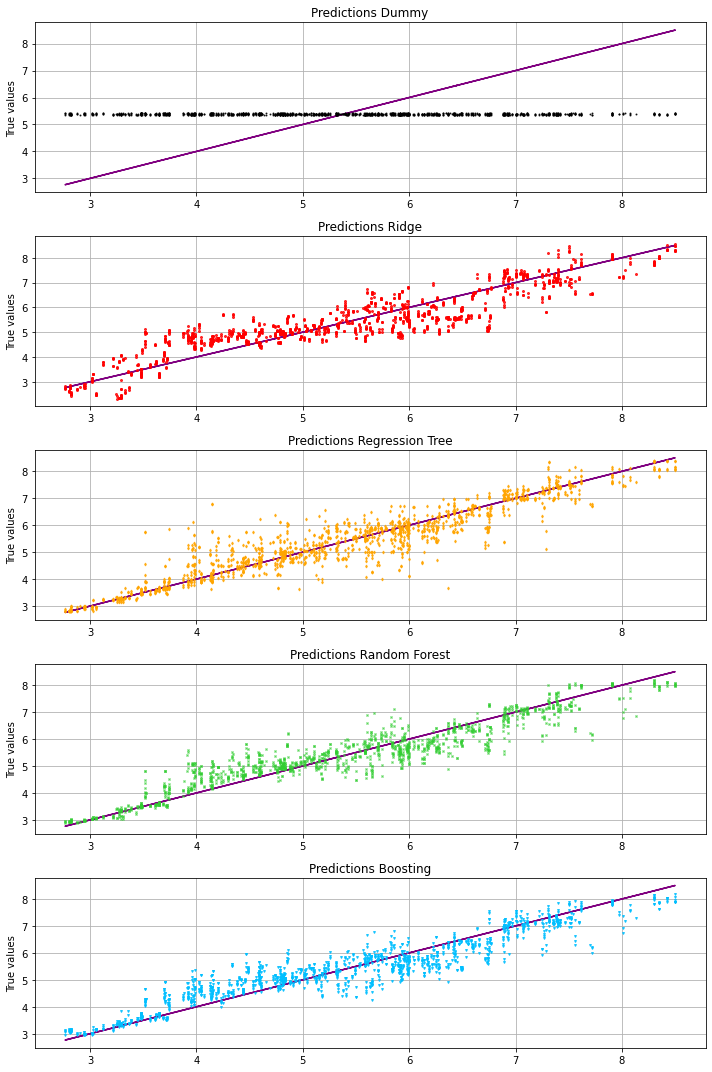

In [21]:
plot_prediction(experiments, actuals)

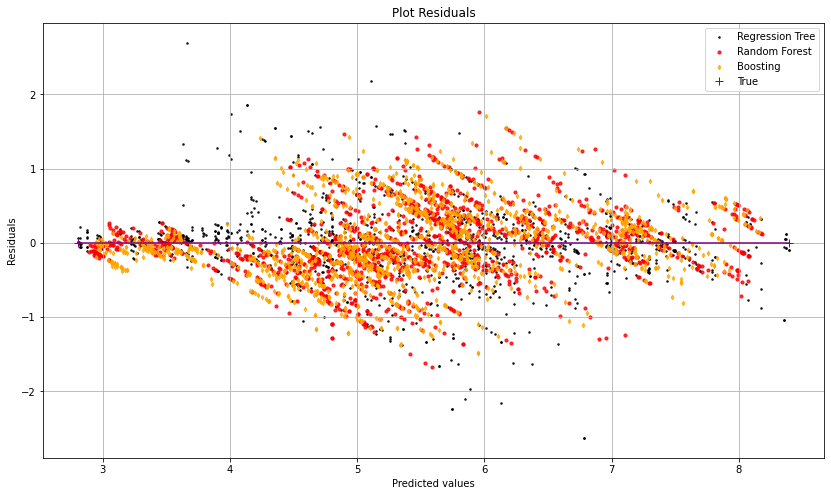

In [22]:
#
remove = ['Dummy', 'Ridge']

plot_residuals({n: p for n, p in experiments.items() if n not in remove}, actuals)

Another way to compare different regressors is to use the relative error.
The relative error for a prediction $\hat{y_i}$ is:
$$
\begin{equation}
    relative\_error = \frac{\hat{y}_i - y_i}{1 + |y_i|}
\end{equation}
$$
In words, the relative error is the difference between the exact value and the approximation divided by the magnitude of the exact value.

In [23]:
def relative_error(p, y):
    return (p - y) / (1 + abs(y))

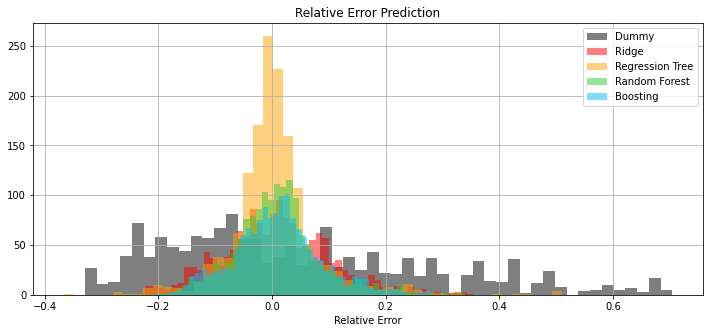

In [24]:
def plot_relative_error(preds, actual):
    plt.figure(figsize=(12, 5))

    for idx, (name, pred) in enumerate(preds.items()):
        re = relative_error(pred, actual)

        # Note that we sort the relative error on the magnetude
        plt.hist(re, 50, color=colors[idx], label=name, alpha=0.5)

    plt.title('Relative Error Prediction')
    plt.xlabel('Relative Error')
    plt.grid()
    plt.legend()
    plt.show()
    
#
plot_relative_error(experiments, actuals)

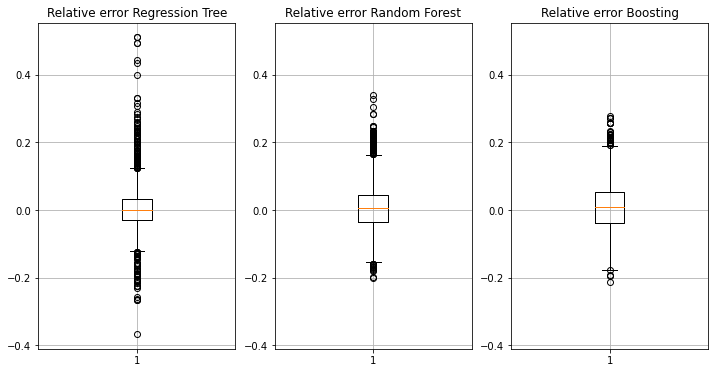

In [25]:
selected_algs = ['Regression Tree', 'Random Forest', 'Boosting']

plt.figure(figsize=(12, 6))

for idx, alg in enumerate(selected_algs):
    pred = experiments[alg]
    
    plt.subplot(1, 3, idx+1, sharey=plt.gca())

    plt.title(f'Relative error {alg}')
    plt.boxplot(relative_error(pred, actuals))
    plt.grid()
    
plt.show()

> **Comment:** from the above boxplots we see that the Regression Tree makes larger errors compared to Random Forest, but it is more accurate on average.

#### 2. Cross validation

Visualizations only take us so far without a clear winner.
Let's use `model_selection.cross_validate` to have a less biased assessment of the train/test split process. (K-Fold Cross Validation)

In [26]:
from sklearn.model_selection import cross_validate

# 
experiments = {}

for name, make_model in algorithms.items():
    experiments[name] = cross_validate(
        make_model(), 
        y=y, 
        X=x,
        scoring={
            'mae': 'neg_mean_absolute_error', 
            'mape': 'neg_mean_absolute_percentage_error',
            'mse': 'neg_mean_squared_error',
            'me': 'max_error'
        },
        cv=10
    )

In [27]:
experiments["Dummy"]

{'fit_time': array([0.00193596, 0.00115085, 0.00085568, 0.00094891, 0.00089788,
        0.00089073, 0.00090694, 0.00080895, 0.00074315, 0.00079203]),
 'score_time': array([0.00127888, 0.00114298, 0.00112104, 0.00107598, 0.00111198,
        0.00108504, 0.00108099, 0.00106215, 0.00114894, 0.00104403]),
 'test_mae': array([-1.41909646, -1.11188538, -1.10018161, -1.06154199, -1.01739501,
        -0.90930793, -1.12409688, -0.9095011 , -1.27901226, -1.40609274]),
 'test_mape': array([-0.24891191, -0.22116949, -0.22411508, -0.20869638, -0.23355721,
        -0.19682534, -0.22825244, -0.19034167, -0.30203319, -0.29380697]),
 'test_mse': array([-2.72009647, -1.71000382, -1.6657629 , -1.53265847, -1.55203629,
        -1.46115892, -1.73052402, -1.08116282, -2.47351522, -2.37503795]),
 'test_me': array([-3.17281015, -2.51958322, -2.14616361, -2.14575717, -2.52853761,
        -2.60548321, -2.62515637, -1.96044645, -3.09422192, -2.91228776])}

In [28]:
pd.DataFrame([{
    'Algorithm': alg,
    'MAE avg': -res["test_mae"].mean(),
    'MAE std': res["test_mae"].std(),
    'MAPE avg': -res["test_mape"].mean(),
    'MAPE std': res["test_mape"].std(),
    'MSE avg': -res["test_mse"].mean(),
    'MSE std': res["test_mse"].std(),
    'ME avg': -res["test_me"].mean(),
    'ME std': res["test_me"].std(),
} for alg, res in experiments.items()])

,Algorithm,MAE avg,MAE std,MAPE avg,MAPE std,MSE avg,MSE std,ME avg,ME std
0,Dummy,1.133811,0.172571,0.234771,0.035561,1.830196,0.491650,2.571045,0.386662
1,Ridge,0.534559,0.123972,0.105340,0.021215,0.450109,0.187170,1.468975,0.234963
2,Regression Tree,0.358577,0.086186,0.068195,0.015209,0.289389,0.114983,1.719925,0.309886
3,Random Forest,0.388539,0.097368,0.074406,0.016510,0.264469,0.142903,1.357360,0.469303
4,Boosting,0.439021,0.106343,0.084908,0.016085,0.319773,0.155132,1.370200,0.297565


> **Comment:** with a less biased assessment we find out that the best performing model is **Random Forest**. Also Decision Tree is ok.

## Generate sales predictions

At this point, we use the entire dataset to train the Random Forest and make predictions for the "Sales"-less table of the super bowl promotion.

In [29]:
alg = algorithms['Random Forest']()

# Train the model on training set
alg.fit(y=y, X=x)

RandomForestRegressor(min_samples_leaf=6, min_samples_split=13, n_estimators=50,
                      random_state=12345)

Before predicting, we must ensure that the data undergoes the same preprocessing of the training data.

In [30]:
superbowl = pd.read_csv('./SodaSuperbowl.csv')
superbowl.head()

,Product,Cost Per Unit,Easter Included,Super Bowl Included,Christmas Included,Other Holiday,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 weeks,Sales M-5 weeks,Family
0,Crisp Clear,1.3425,No,Yes,No,No,80.79,71.12,21.525000,22.075000,30.125,39.400,38.775000,Clear
1,Popsi Kola,1.7125,No,Yes,No,No,80.79,71.12,48.775000,38.025000,31.025,31.300,27.550000,Dark
2,Alpine Stream,1.9975,No,Yes,No,No,80.79,71.12,15.525000,6.475000,5.175,6.525,5.300000,Clear
3,Koala Kola,2.5650,No,Yes,No,No,80.79,71.12,369.150000,416.675000,352.600,375.350,442.225000,Dark
4,Bright,1.2900,No,Yes,No,No,80.79,71.12,1020.466667,1057.933333,920.400,808.200,830.466667,Clear


In [31]:
superbowl.describe()

,Cost Per Unit,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 weeks,Sales M-5 weeks
count,36.000000,36.00,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000
mean,2.175486,80.79,7.112000e+01,182.947222,188.908333,168.394444,157.591667,162.855556
std,0.781909,0.00,1.441244e-14,282.663256,298.260088,257.273874,230.942185,243.999272
min,1.272500,80.79,7.112000e+01,11.500000,6.475000,5.175000,6.525000,5.300000
25%,1.531250,80.79,7.112000e+01,18.075000,13.496250,13.667500,13.013750,18.762500
50%,1.928750,80.79,7.112000e+01,48.775000,38.025000,31.025000,39.400000,38.775000
75%,2.635625,80.79,7.112000e+01,230.075000,253.125000,211.250000,190.900000,151.675000
max,3.842500,80.79,7.112000e+01,1020.466667,1057.933333,920.400000,808.200000,830.466667


In [32]:
# Copy the data for preprocessing
ds_superbowl = superbowl.copy()

# Make sure Sales is not present
assert "Sales" not in ds_superbowl.columns 

In [33]:
# Scale numerical columns
ds_superbowl.loc[:, numerical_columns] = scaler.transform(ds_superbowl.loc[:, numerical_columns])

# Check categorical
for c in categorical_columns:
    print(c.upper())
    print(ds_superbowl[c].value_counts(), '\n')

PRODUCT
Mr. Popper       5
Crisp Clear      4
Popsi Kola       4
Alpine Stream    4
Koala Kola       4
11 Down          4
DC Kola          4
AB Root Beer     4
Bright           3
Name: Product, dtype: int64 

FAMILY
Dark     21
Clear    15
Name: Family, dtype: int64 

EASTER INCLUDED
No    36
Name: Easter Included, dtype: int64 

SUPER BOWL INCLUDED
Yes    36
Name: Super Bowl Included, dtype: int64 

CHRISTMAS INCLUDED
No    36
Name: Christmas Included, dtype: int64 

OTHER HOLIDAY
No    36
Name: Other Holiday, dtype: int64 



> **Note**: there are values not present in the superbowl data. For instance, there isn't any CHRISTMAS INCLUDED yes.

In [34]:
ds_superbowl = pd.get_dummies(ds_superbowl, columns=categorical_columns)

# Check nothing more that training set
assert set(ds_superbowl.columns).issubset(set(x.columns))

#
print('Number of instances in training data:', len(dataset))
print('Number of instances in super bowl data:', len(ds_superbowl))

# Add missing columns by assigning a dafault value ()
for fld in set(x.columns).difference(ds_superbowl.columns, {"Sales"}):
    print(fld)
    ds_superbowl[fld] = 0

#
set(ds_superbowl.columns) == set(x.columns)

Number of instances in training data: 596
Number of instances in super bowl data: 36
Easter Included_Yes
Christmas Included_Yes
Super Bowl Included_No


True

In [35]:
ds_superbowl.describe()

,Cost Per Unit,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 weeks,Sales M-5 weeks,Product_11 Down,Product_AB Root Beer,...,Product_Popsi Kola,Family_Clear,Family_Dark,Easter Included_No,Super Bowl Included_Yes,Christmas Included_No,Other Holiday_No,Easter Included_Yes,Christmas Included_Yes,Super Bowl Included_No
count,36.000000,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.000000,36.000000,36.000000,36.0,36.0,36.0,36.0,36.0,36.0,36.0
mean,0.049368,8.199438e-01,-2.457453e-02,0.233233,0.269396,0.186905,0.151259,0.178851,0.111111,0.111111,...,0.111111,0.416667,0.583333,1.0,1.0,1.0,1.0,0.0,0.0,0.0
std,1.029841,1.125972e-16,7.037323e-18,1.273016,1.377804,1.210578,1.111407,1.174425,0.318728,0.318728,...,0.318728,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-1.139942,8.199438e-01,-2.457453e-02,-0.538905,-0.573349,-0.581109,-0.575748,-0.579500,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0
25%,-0.799146,8.199438e-01,-2.457453e-02,-0.509293,-0.540915,-0.541148,-0.544521,-0.514702,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0
50%,-0.275605,8.199438e-01,-2.457453e-02,-0.371031,-0.427605,-0.459474,-0.417537,-0.418377,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0
75%,0.655410,8.199438e-01,-2.457453e-02,0.445480,0.566043,0.388557,0.311556,0.125037,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0
max,2.244968,8.199438e-01,-2.457453e-02,4.005128,4.283832,3.725395,3.282306,3.392218,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0


> **Take care!!** `sklearn` [has no concept of columns names](https://github.com/scikit-learn/scikit-learn/issues/7242). We make sure that the `superbowl` columns are ordered consistently with the `dataset` independent column sub-matrix.

In [36]:
# Sort the columns as in training
ds_superbowl = ds_superbowl[list(x.columns)]

In [37]:
# Revert log scale and round to the lower int
y_pred = alg.predict(ds_superbowl)
y_pred = np.e ** y_pred
superbowl["Sales"] = y_pred.astype(int)

In [38]:
superbowl.head(8)

,Product,Cost Per Unit,Easter Included,Super Bowl Included,Christmas Included,Other Holiday,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 weeks,Sales M-5 weeks,Family,Sales
0,Crisp Clear,1.3425,No,Yes,No,No,80.79,71.12,21.525000,22.075000,30.125,39.400,38.775000,Clear,76
1,Popsi Kola,1.7125,No,Yes,No,No,80.79,71.12,48.775000,38.025000,31.025,31.300,27.550000,Dark,125
2,Alpine Stream,1.9975,No,Yes,No,No,80.79,71.12,15.525000,6.475000,5.175,6.525,5.300000,Clear,193
3,Koala Kola,2.5650,No,Yes,No,No,80.79,71.12,369.150000,416.675000,352.600,375.350,442.225000,Dark,1441
4,Bright,1.2900,No,Yes,No,No,80.79,71.12,1020.466667,1057.933333,920.400,808.200,830.466667,Clear,2771
5,11 Down,1.5375,No,Yes,No,No,80.79,71.12,18.925000,14.175000,14.550,13.825,22.250000,Clear,191
6,Koala Kola,2.5350,No,Yes,No,No,80.79,71.12,369.150000,416.675000,352.600,375.350,442.225000,Dark,1419
7,Alpine Stream,2.1500,No,Yes,No,No,80.79,71.12,15.525000,6.475000,5.175,6.525,5.300000,Clear,185


At this point, we found a way to predict the sales of a promotion.
Let's make use of it with Gurobi.

----
## Optimization: soda promotion

### Sets and Indices:
- $t \in F = \{ \text{Dark}, \text{Clear} \}$: Set of soda families.

- $s \in S$: Set of sodas.

- $S_t \subset S$: set of sodas that belong to the same family $t \in F$.

- $p \in P_s \subset \mathbb{R}$: it is the set of prices for a soda $s \in S$.

- $p_s$: normal price for soda $s \in S$.


### Parameters:
- $max_t \in \mathbb{N}$: maximum number of sodas that can be discounted for a family $t \in F$.

- $max_{investment} \in \mathbb{R}^+$: max investment for the discouts.

- $f_{s, p}$: predicted sales for a soda $s$ sold at a price $p$.


### Decision Variables:

- $X_{s, p} \in \{0,1\}$: 1 if we sell the soda $s$ at the price $p$ during the super bowl, 0 otherwise.


### Objective Function:

- **Total sales**: Maximize the total sales:

\begin{equation}
\text{Max} \quad \sum_{s \in S} \sum_{p \in P_s} f_{s, p} X_{s, p}
\tag{0}
\end{equation}


### Constraints:

- **Product price**: select a single price for a product:

\begin{equation}
\sum_{p \in P_s} X_{s, p} = 1 \quad \forall s \in S
\tag{1}
\end{equation}

- **Max promo family**: maximum number of sodas of the same family that can be discounted simultaneously:

\begin{equation}
\sum_{s \in S_t} \sum_{p \in P \, \land \, p \neq p_s} X_{s, p} \leq max_t \quad\forall t \in F
\tag{2}
\end{equation}

- **Max investment**: the increment in the sales given by the discout must be lower than the given budget:

\begin{equation}
\sum_{s \in S} \sum_{p \in P_s} \left(p \cdot f_{s, p} - p_s \cdot f_{s, p_s} \right) X_{s, p} <= max_{investment}
\tag{3}
\end{equation}

- **Integrality**:

\begin{equation}
X_{s, p} \in \{0,1\} \quad \forall s \in S \land p \in P_s
\tag{4}
\end{equation}

In [39]:
forecast = superbowl[['Product', 'Cost Per Unit', 'Sales', 'Family']].copy()
forecast.set_index(['Product','Cost Per Unit'], inplace=True)
forecast.sort_index(inplace=True)
forecast

Sales Family
Product       Cost Per Unit              
11 Down       1.4550           242  Clear
              1.5125           216  Clear
              1.5375           191  Clear
              1.5600           154  Clear
AB Root Beer  3.7300           351   Dark
              3.7700           351   Dark
              3.8125           351   Dark
              3.8425           346   Dark
Alpine Stream 1.9975           193  Clear
              2.1375           189  Clear
              2.1500           185  Clear
              2.2275           153  Clear
Bright        1.2725          3268  Clear
              1.2825          2902  Clear
              1.2900          2771  Clear
Crisp Clear   1.3125            78  Clear
              1.3425            76  Clear
              1.4275            55  Clear
              1.4700            48  Clear
DC Kola       1.8900           601   Dark
              1.9150           518   Dark
              1.9250           468   Dark
              1.9325           463   Dark
Koala Kola    2.4825          1415   Dark
              2.5350          1419   Dark
              2.5600          1441   Dark
              2.5650          1441   Dark
Mr. Popper    2.8475            33   Dark
              2.8925            33   Dark
              2.8950            33   Dark
              2.9000            33   Dark
              2.9850            30   Dark
Popsi Kola    1.6725           134   Dark
              1.7125           125   Dark
              1.7275           126   Dark
              1.7500           126   Dark

In [40]:
# Parameters:
soda_family = set(superbowl.Family.unique())
print('Soda families:', soda_family)

sodas = set(superbowl.Product.unique())
print('Sodas:', sodas)

# We allow to discount only two sodas for each family
max_promo = {f: 2 for f in soda_family}

#
max_investment = 750

Soda families: {'Dark', 'Clear'}
Sodas: {'Crisp Clear', '11 Down', 'Alpine Stream', 'Bright', 'Mr. Popper', 'AB Root Beer', 'DC Kola', 'Koala Kola', 'Popsi Kola'}


> We assume that the maximum price of a soda is the normal one $p_s$.

In [41]:
#
product_prices = set(forecast.index.values)

#
normal_price = {s: 0 for s in sodas}
for soda, price in product_prices:
    normal_price[soda] = max(normal_price[soda], price)

print('Normal price:')
normal_price

Normal price:


{'Crisp Clear': 1.47,
 '11 Down': 1.56,
 'Alpine Stream': 2.2275,
 'Bright': 1.29,
 'Mr. Popper': 2.985,
 'AB Root Beer': 3.8425,
 'DC Kola': 1.9325,
 'Koala Kola': 2.565,
 'Popsi Kola': 1.75}

> Note that not all the estimated discounts yield a boost in sales:

In [42]:
meaningful_discounts = 0

for s, price in product_prices:
    if forecast.Sales[s, price] > forecast.Sales[s, normal_price[s]]:
        meaningful_discounts += 1
        
print('Number of discounts that increase the sales:', meaningful_discounts)

Number of discounts that increase the sales: 22


### Building the model and results

In [44]:
import gurobipy as gu
from gurobipy import GRB

model = gu.Model()

# Variables
select_price = model.addVars(product_prices, vtype=GRB.BINARY, name='X')
investment   = model.addVar(ub=max_investment, name='investment')

# Product price
model.addConstrs((select_price.sum(s, '*') == 1 for s in sodas), name='OnePrice')

# Max promo family
model.addConstrs((gu.quicksum(select_price[s, p] for s, p in product_prices 
                              if forecast.Family[s, p] == t and p != normal_price[s]) <= max_promo[t] 
                  for t in soda_family),
                  name='MaxProm')

# Investment
# model.addConstr(investment == gu.quicksum(max(0, forecast_sales.Sales[s, p] - forecast_sales.Sales[s, normal_price[s]]) 
#                                           * normal_price[s] * select_price[s, p] for s, p in product_prices),
#                 name='investment')
model.addConstr(investment == gu.quicksum(
    max(0, forecast.Sales[s, p] * p - forecast.Sales[s, normal_price[s]] * normal_price[s]) 
    * select_price[s, p] for s, p in product_prices if p != normal_price[s]),
                name='investment')

# Objective
sales = select_price.prod(forecast.Sales.to_dict())
model.setObjective(sales, sense=gu.GRB.MAXIMIZE)

model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 37 columns and 84 nonzeros
Model fingerprint: 0xce58615f
Variable types: 1 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [3e+01, 3e+03]
  Bounds range     [1e+00, 8e+02]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 5532.0000000
Presolve removed 5 rows and 22 columns
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 39 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)
Found heuristic solution: objective 6130.0000000

Root relaxation: objective 6.157894e+03, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6156.00993    0    2 6130.00000 6156.00993  0.42%     -  

In [45]:
print(f'Is the solution optimal? {model.status == gu.GRB.OPTIMAL}')
print(f"Sold sodas: {model.ObjVal:.0f}\n")

print(f'\t{"Soda  ":6}|\t    Price')
print('-'*28)
for k, v in select_price.items():
    if v.x != 0:
        print(f'{k[0]:13} | {k[1]:10.4f}')

Is the solution optimal? True
Sold sodas: 6132

	Soda  |	    Price
----------------------------
Alpine Stream |     1.9975
Crisp Clear   |     1.4700
Mr. Popper    |     2.9850
Popsi Kola    |     1.6725
AB Root Beer  |     3.8425
11 Down       |     1.5600
DC Kola       |     1.9150
Bright        |     1.2725
Koala Kola    |     2.5650


In [46]:
print(f'Total investement = {investment.x:.5f}')

Total investement = 729.48750


## Analysis
> Only the paranoid survive!

#### What do we discount?

In [47]:
price_selections = {"Product":[], "Price":[], "Is Discount":[], "Family":[]}

# For each pair (product, price)
for s, price in product_prices:
    if select_price[s, price].X > 0.5: 
        price_selections["Product"].append(s)
        price_selections["Price"].append(price)
        price_selections["Is Discount"].append(price < normal_price[s])
        price_selections["Family"].append(forecast.Family[s, price])
        
pd.DataFrame(price_selections).set_index("Product").sort_values('Family')

,Price,Is Discount,Family
Product,,,
Alpine Stream,1.9975,True,Clear
Crisp Clear,1.4700,False,Clear
11 Down,1.5600,False,Clear
Bright,1.2725,True,Clear
Mr. Popper,2.9850,False,Dark
Popsi Kola,1.6725,True,Dark
AB Root Beer,3.8425,False,Dark
DC Kola,1.9150,True,Dark
Koala Kola,2.5650,False,Dark


In [48]:
def revenue(select_price, product_prices):
    """
    Compute the revenue, i.e., the sum of expected (forcasted) income.
    """
    rev = 0
    for s, price in product_prices:
        if select_price[s, price].X > 0.5: 
            rev += price * forecast.Sales[s, price]
    return rev

print(f'Revenue: {revenue(select_price, product_prices):.2f}')

Revenue: 11186.15


#### Simulate different conditions

**How robust is the campaign to the prediction?**

Create a range of predictions to simulate different behaviors. <br>
We can evaluate the robustness of the decision by keeping the same discounted prices by forcing fluctuations in the sales.
The fluctuations can be achived by using other regressors trained with different random states or on part of the training data.

In [49]:
def compute_KPI(_forecast, xx):
    """
    Compute KPI for a forcasted scenario.
    
    Arga:
        _forcast: (DataFrame)
            The prediction of the regressor.
        xx: (Gurobi variable)
            The decision.
    """
    sales, revenue, investment = 0, 0, 0
    #
    for s, p in product_prices:
        sales   += _forecast.Sales[s, p] * xx[s, p].X
        revenue += _forecast.Sales[s, p] * p * xx[s, p].X
        #
        diff = max(0, _forecast.Sales[s, p] * p - _forecast.Sales[s, normal_price[s]] * normal_price[s])
        investment += diff * xx[s, p].X
    return sales, revenue, investment

In [50]:
simulated_KPI = {'Sales':[], 'Revenue':[], 'Investment':[], 'Feasible': []}

for i in range(40):
    # Fit a regressor
    reg = RandomForestRegressor(n_estimators=50,
                                min_samples_split=13,
                                min_samples_leaf=6,
                                n_jobs=4, 
                                random_state=i*123).fit(y=y, X=x)
    
    # Predict the sales
    superbowl["Sales"] = np.e ** reg.predict(ds_superbowl)
    forecast = superbowl[['Product', 'Cost Per Unit', 'Sales', 'Family']].copy()
    forecast = forecast.set_index(['Product','Cost Per Unit'])
    
    # KPI
    sales, revenue, investment = compute_KPI(forecast, select_price)
    simulated_KPI['Feasible'].append(investment <= max_investment)
    simulated_KPI['Sales'].append(sales)
    simulated_KPI['Revenue'].append(revenue)
    simulated_KPI['Investment'].append(investment)

df = pd.DataFrame(simulated_KPI)
print(f'Number of infeasible solution: {df.Feasible.sum()}')

Number of infeasible solution: 21


In [51]:
df.describe()

,Sales,Revenue,Investment
count,40.000000,40.000000,40.000000
mean,6250.118634,11266.954130,786.218495
std,140.851378,211.577102,163.440872
min,5905.088772,10732.031714,417.327745
25%,6143.326513,11139.812576,688.573161
50%,6237.919274,11244.606632,747.134492
75%,6343.409869,11430.342466,905.924835
max,6546.833902,11666.571280,1143.839505


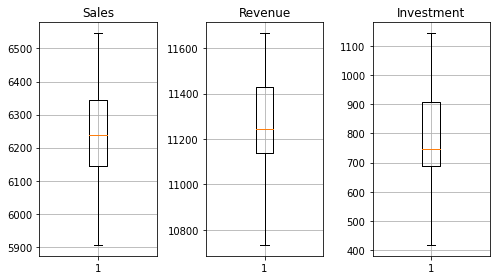

In [52]:
plt.figure(figsize=(7,4))

for idx, t in enumerate(['Sales', 'Revenue', 'Investment']):
    ax = plt.subplot(1, 3, idx+1)
    ax.boxplot(simulated_KPI[t])
             #color=next(color), 
             #alpha=0.75)
    ax.set_title(t)
    ax.grid(True)
    
plt.tight_layout()
plt.show()

#### Ex1: Evaluate the robustness of the decision for models and training sets

Don't use Random Forest but whatever you want!

#### Ex2: Which is the right max investment?

# References for Stochastic, Robust, and Risk optimization

The following list is an (incomplete) list of sources for these topics, but a good starting point for it.

**Books**

<ul>
    <li>Stochastic Programming, Peter Kall, Stein W. Walace, 1994</li>
    <li>Optimization Methods in Finance, Gerard Cornuejols and Reha T&uuml;t&uuml;nc&uuml;, 2006</li>
    <li>Lectures on Stochastic Programming: Modeling and Theory, Alexander Shapiro, Darinka Dentcheva, Andrzej Ruszczy&nacute;ski, 2009</li>
    <li>Robust Optimization, Aharon Ben-Tal, Laurent El Ghaoui, Arkadi Nemirovski, 2009</li>
    <li>Introduction to Stochastic Programming, John Birge, Fran&ccedil;ois Louveaux, 2011</li>
    <li>Modeling with Stochastic Programming, Alan J. King, Stein W. Walace, 2012</li>
</ul>

**Some papers**

<ul>
    <li>Optimization of Conditional Value-at-Risk, R. Tyrrell Rockafellar, Stanislav Uryasev, 2000</li>
    <li>Supplier-Retailer Flexible Commitments Contracts: A Robust Optimization Approach, Aharon Ben Tal , Boaz Golany, Arcadi Nemirovskiy, Jean-Philippe Vial, 2003</li>
    <li>Tractable Approximations to Robust Conic Optimization Problems,Dimitris Bertsimas, Melvyn Sim, 2006</li>
    <li>Modeling and optimization of risk, Pavlo Krokhmal, Michael Zabarankin,Stan Uryasev, 2011</li>
</ul>